<a href="https://colab.research.google.com/github/DataMastersUN/FA_T3/blob/main/Trabajo_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# **Fundamentos de Analítica**

##**Trabajo 3: Clasificación de Imágenes**

Integrantes:

David Antonio Castro Tamayo
dcastrot@unal.edu.co

Luis Javier Asprilla Galarcio
lasprilla@unal.edu.co

Anderson Elian Gutierrez Bueno
angutierrezb@unal.edu.co

</center>

Se tiene un conjunto de imágenes de personas con y sin gafas, en las que los individuos aparecen con diferentes expresiones faciales y ángulos, descargado de la fuente:https://archive.ics.uci.edu/ml/datasets/CMU+Face+Images

Objetivo: Construir y validar un modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas con el conjunto de datos dado.

In [44]:
# Librerias usadas
import os
import cv2
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage import io
from random import shuffle
from tensorflow import keras
from collections import Counter
from keras.models import Sequential
from random import randint, choice, choices
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, Activation, BatchNormalization
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# **Carga de datos**

Mounted at /content/drive


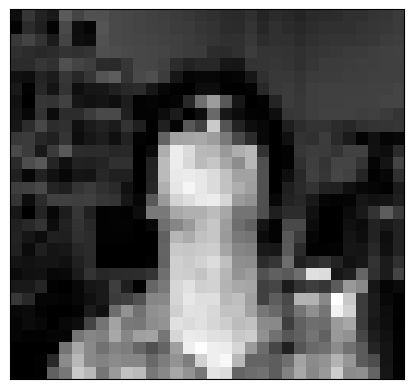

In [4]:
from google.colab import drive
drive.mount('/content/drive')

imagen = Image.open('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces_4/an2i/an2i_up_sad_sunglasses_4.pgm')
plt.imshow(imagen, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

Los datos, tanto las imágenes como las etiquetas, se guardaron en dos únicos archivos binarios para evitar la carga reiterada de todas las imágenes desde el destino. Y se procede a cargar y trabajar con dichos ficheros.

In [5]:
ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/imagenes.pkl'

with open(ruta_archivo, 'rb') as archivo:
    images = pickle.load(archivo)
print(f'Se encontraron {len(images)} imágenes PGM.')

Se encontraron 624 imágenes PGM.


In [6]:
ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/labels.pkl'

with open(ruta_archivo, 'rb') as archivo:
    labels = pickle.load(archivo)
print(f'Se encontraron {len(labels)} labels')

Se encontraron 624 labels


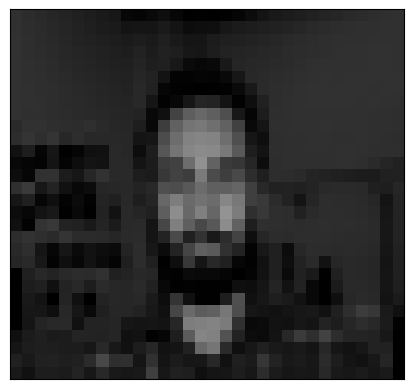

In [7]:
#Comprobación de carga correcta de datos
plt.imshow(images[134], cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
images[7].shape

(30, 32, 3)

Estos números representan en la imagen actual, el alto, ancho y canales de color, respectivamente. El canal de color con el valor de 3 hace referencia a que cada pixel tiene tres valores: rojo, verde y azul.

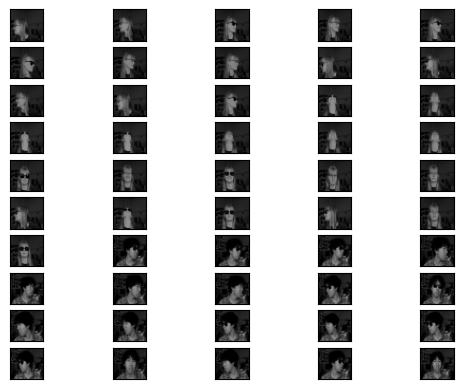

In [9]:
#Muestra de las imágenes guardadas
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

# **Preprocesamiento de datos**

## Transformación a escala de grises, redimensionamiento y normalización de imágenes

In [10]:
#Transformación explícita a grises
images_gray = []
for i in range(len(images)):
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    images_gray.append(image)

images_gray[4].shape

(30, 32)

Ahora sólo aparecen dos valores, alto y ancho, indicando que, actualmente, las imágenes se encuentran guardadas en escala de grises con una sola dimensión de canal. En cada píxel en la imagen en blanco y negro, los valores suelen estar en el rango de 0 a 255, donde 0 representa negro y 255 representa blanco, los valores intermedios representan tonos de gris.

Esta dimensión de alto y ancho es la que se utilizará a continuación para estandarizar todas las imágenes a una misma dimensión.

In [11]:
#Redimensión de todas las imagenes a un tamaño estandar de 30x32
new_height = images[0].shape[0]
new_width = images[0].shape[1]
images_proc = []
for i in range(len(images_gray)):
    image = cv2.resize(images_gray[i],(new_width, new_height))
    images_proc.append(image)

Se procede con la **normalización de pixeles**, dividiendo cada valor de píxel por el valor máximo posible (255 en el caso de imágenes en escala de grises).
Esto normalizará los valores de píxeles en el rango de [0, 1].

In [12]:
#Normalización
images_normalized = []
for i in range(len(images_proc)):
    image = images_proc[i] / 255.0
    images_normalized.append(image)

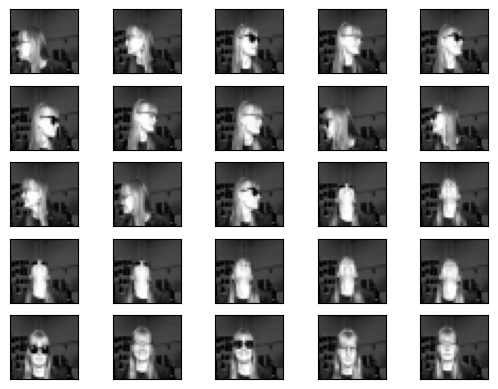

In [15]:
#Muestra de imágenes para ver el estado de las mismas luego de las transformaciones
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_normalized[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

## **Análisis de imágenes por clase**

In [27]:
#Valores únicos en la variable objetivo
print(set(labels))

{'open', 'sunglasses'}


In [18]:
print({label: labels.count(label) for label in set(labels)})

{'open': 313, 'sunglasses': 311}


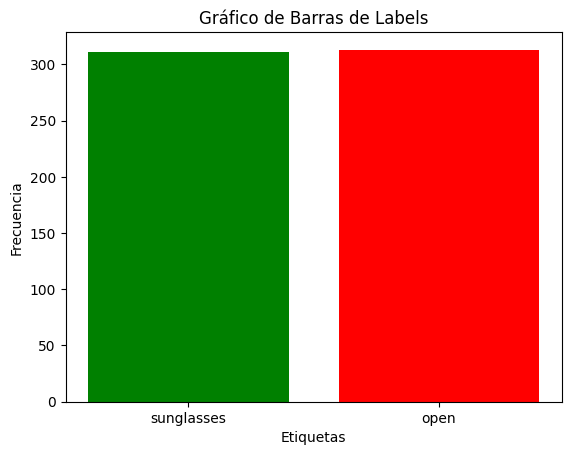

In [26]:
contador = Counter(labels)
etiquetas_unicas = list(contador.keys())
frecuencias = list(contador.values())

# Crear el gráfico de barras
plt.bar(etiquetas_unicas, frecuencias, color=['green','red'])
plt.xlabel('Etiquetas')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras de Labels')
plt.show()

Basándonos en los resultados previos, se concluye que de las 624 imágenes de caras, 313 no presentan gafas ('open'), mientras que 311 sí las tienen ('sunglasses').

Dado el número adecuado de datos para ambos valores únicos de la variable objetivo en el conjunto completo, no se considera necesario realizar un balanceo entre ellos.

# **Declaración de etiquetas y análisis de datos**

*X_train*: Variable de imagenes de entrenamiento.

*y_train*: Label que asigna el tipo de clase de imagenes de entrenamiento.

*X_valid*: Variable de imagenes de validación.

*y_valid*: Label que asigna el tipo de clase de las imagenes de validación.

*X_test*: Variable de imagenes de prueba.

*y_test*: Label que asigna el tipo de clase de las imagenes de prueba.

**Clasificación de imágenes**:

0 : open (sin gafas)

1 : sunglasses (con gafas)


<center>

In [40]:
#Partición de los datos en train 70%, test 15%, y validation 15%
X_train, temp_data, y_train, temp_labels = train_test_split(images_normalized, labels, test_size=0.3, random_state=42, stratify=labels)

# Dividir el conjunto temporal para obtener conjuntos de validación y prueba
X_valid, X_test, y_valid, y_test = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

X_train = np.array(X_train); y_train = np.array(y_train)
X_valid = np.array(X_valid); y_valid = np.array(y_valid)
X_test = np.array(X_test); y_test = np.array(y_test)

label_encoder = LabelEncoder()

# Convierte las etiquetas a números
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

En la sección anterior se hace la división de los datos en entrenamiento, prueba y validación, indicando que las etiquetas deben ser consideradas al realizarla. Así se asegura que los conjuntos tengan una representación equitativa de las clases originales.

In [41]:
modelo_keras = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(30, 32, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

modelo_keras.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 30, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 26, 28, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 13, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 11, 12, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 5, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 4, 128)        

In [42]:
# Compilacion
modelo_keras.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
CB = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)
]

# Entrenamiento
history = modelo_keras.fit(
    X_train,  # Datos de entrenamiento
    y_train_encoded,  # Etiquetas de entrenamiento
    epochs=60,
    callbacks=CB,
    batch_size=32,
    validation_data=(X_valid, y_valid_encoded)  # Datos de validación
)


Epoch 1/60
14/14 [==============================] - 3s 124ms/step - loss: 0.6969 - accuracy: 0.4954 - val_loss: 0.6934 - val_accuracy: 0.3936
Epoch 2/60
14/14 [==============================] - 1s 75ms/step - loss: 0.6944 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/60
14/14 [==============================] - 2s 117ms/step - loss: 0.6931 - accuracy: 0.5138 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/60
14/14 [==============================] - 2s 130ms/step - loss: 0.6933 - accuracy: 0.5046 - val_loss: 0.6933 - val_accuracy: 0.4468
Epoch 5/60
14/14 [==============================] - 2s 131ms/step - loss: 0.6933 - accuracy: 0.5161 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/60
14/14 [==============================] - 2s 133ms/step - loss: 0.6937 - accuracy: 0.4908 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/60
14/14 [==============================] - 2s 110ms/step - loss: 0.6935 - accuracy: 0.4839 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 7

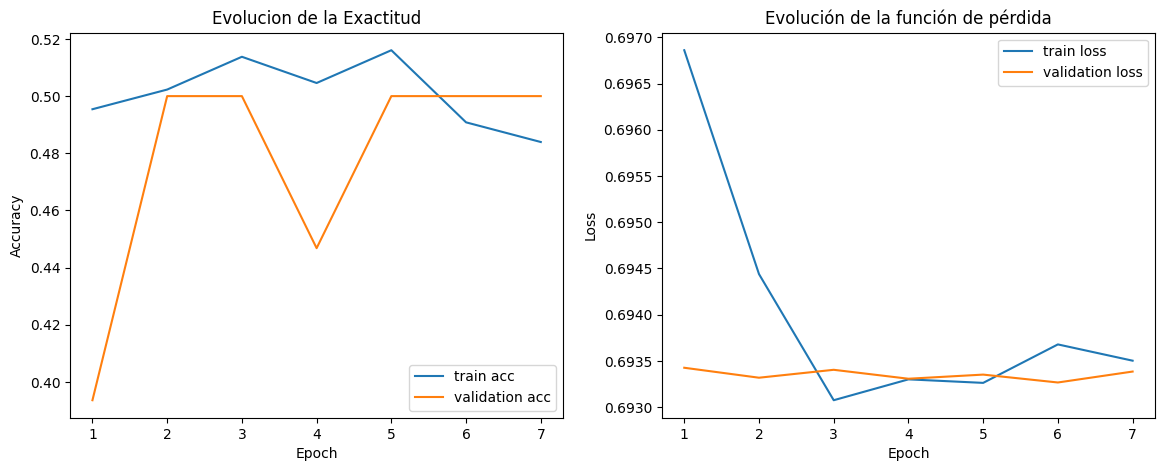

In [43]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolución de la función de pérdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()


ENTRENAMIENTO Y VALIDACIÓN:

14/14 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       219
           1       0.00      0.00      0.00       217

    accuracy                           0.50       436
   macro avg       0.25      0.50      0.33       436
weighted avg       0.25      0.50      0.34       436



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



PRUEBA:

3/3 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        47
           1       0.00      0.00      0.00        47

    accuracy                           0.50        94
   macro avg       0.25      0.50      0.33        94
weighted avg       0.25      0.50      0.33        94



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


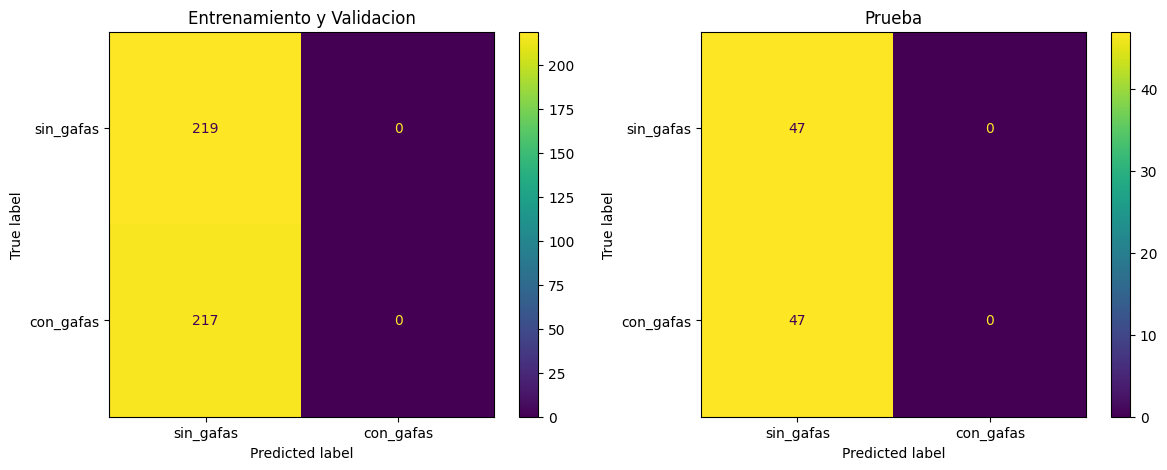

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

print("\nENTRENAMIENTO Y VALIDACIÓN:\n")

y_pred = np.argmax(modelo_keras.predict(X_train), axis=1)

print(classification_report(y_train_encoded, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_train_encoded,
    y_pred = y_pred,
    display_labels = ['sin_gafas','con_gafas'],
    ax = ax1
)
ax1.set_title("Entrenamiento y Validacion")

print("\nPRUEBA:\n")

y_pred = np.argmax(modelo_keras.predict(X_test), axis=1)

print(classification_report(y_test_encoded, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_test_encoded,
    y_pred = y_pred,
    display_labels = ['sin_gafas','con_gafas'],
    ax = ax2
)
ax2.set_title("Prueba")

plt.show()

In [ ]:
#ancho, alto = imagen.size
#print(f"Tamaño de la imagen: {ancho}x{alto}")

# También puedes acceder a los píxeles de la imagen
#pixeles = list(imagen.getdata())
#print(f"Primer píxel: {pixeles[0]}")

# Cierra la imagen
#imagen.close()



# #CODIGO INICIAL PARA AÑADIR TODAS LAS IMAGENES A UN LISTA ESTÁTICA, Y ASÍ NO TENER QUE CARGAR TODAS LAS IMÁGENES CADA VEZ QUE SE EJECUTE EL CÓDGO

# # Ruta a la carpeta raíz que contiene las subcarpetas con las imágenes PGM
# ruta_raiz = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/faces_4'
# rutas_imagenes = []
# # Recorre las subcarpetas y busca las imágenes PGM
# for directorio_raiz, directorios, archivos in os.walk(ruta_raiz):
#     for archivo in archivos:
#         if archivo.lower().endswith('.pgm'):
#             # Construye la ruta completa al archivo
#             ruta_completa = os.path.join(directorio_raiz, archivo)
#             rutas_imagenes.append(ruta_completa)
# # Ahora tienes todas las rutas de las imágenes PGM en la lista rutas_imagenes
# # Puedes cargar las imágenes si es necesario

# etiquetas = [ruta.split('_')[-2].split('.')[0] for ruta in rutas_imagenes]

# # Para verificar la cantidad de imágenes

# # Para acceder a una imagen específica
# print(set(etiquetas))



# # Ruta en Google Drive donde guardar el archivo
# ruta_archivo = '/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto3/labels.pkl'
# with open(ruta_archivo, 'wb') as archivo:
#     pickle.dump(etiquetas, archivo)